# Загрузка Pandas и очистка данных

In [73]:
import pandas as pd
import ast
import warnings
import seaborn as sns 

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [74]:
df = pd.read_csv('main_task_new.csv')

In [75]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

In [76]:
#Меняем названия столбиков для удобства
df.columns = ['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Rating',
       'Price_Range', 'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA']

In [77]:
#проверяем в каких столбиках есть пропущенные значения 
df.isna().any()

Restaurant_id        False
City                 False
Cuisine_Style         True
Ranking              False
Rating               False
Price_Range           True
Number_of_Reviews     True
Reviews              False
URL_TA               False
ID_TA                False
dtype: bool

In [78]:
#убираем столбики, которые не будут использоваться в модели
df = df.drop(['Reviews', 'URL_TA', 'ID_TA'], axis=1)

In [79]:
#работаем с признаком Cuisune Style
#и создаем новый атрибут, кол-во кухонь в ресторане
df['Cuisine_Style'] = df['Cuisine_Style'].fillna("['No Cuisine']")
df['Cuisine_Style'] = df['Cuisine_Style'].apply(ast.literal_eval)
df['Number_of_cuisine'] = df['Cuisine_Style'].apply(lambda x: len(x))

In [80]:
df["Price_Range_val"] = 0
for i in range(0, len(df.Price_Range)):
    if df.Price_Range[i] == '$':
        df["Price_Range_val"][i] = 1
    elif df.Price_Range[i] == '$$ - $$$':
        df["Price_Range_val"][i] = 2
    elif df.Price_Range[i] == '$$$$':
        df["Price_Range_val"][i] = 3
    else:
        df["Price_Range_val"][i] = 0
        

In [81]:
#Заменим наиболее часто встречающимся значением цены по городу
city_price_med = df.groupby('City').Price_Range_val.median()
for i in range(0, len(df.Price_Range)):
    city = df.City[i]
    if df.Price_Range_val[i] == 0:
        df.Price_Range_val[i] = city_price_med[city]

In [82]:
df=pd.get_dummies(df, columns=['Price_Range_val'])

In [83]:
df.columns=['Restaurant_id','City', 'Cuisine_Style','Ranking','Rating', 'Price_Range',
            'Number_of_Reviews', 'Number_of_cuisine', 'no_price','low_price','mid_price','high_price']

In [84]:
#Заменим недостающие значения Number_of_Reviews на 0
#pd.set_option("max_rows", None)
df.Number_of_Reviews = df.Number_of_Reviews.fillna(0)

<AxesSubplot:>

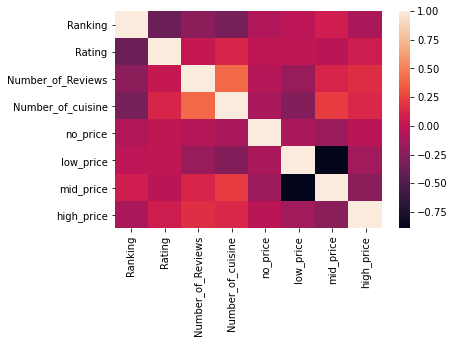

In [85]:
sns.heatmap(df.corr())

In [86]:
df = df.explode('Cuisine_Style')

In [87]:
df=pd.get_dummies(df, columns=['Cuisine_Style'])

In [88]:
df.head()

,Restaurant_id,City,Ranking,Rating,Price_Range,Number_of_Reviews,Number_of_cuisine,no_price,low_price,mid_price,...,Cuisine_Style_Ukrainian,Cuisine_Style_Uzbek,Cuisine_Style_Vegan Options,Cuisine_Style_Vegetarian Friendly,Cuisine_Style_Venezuelan,Cuisine_Style_Vietnamese,Cuisine_Style_Welsh,Cuisine_Style_Wine Bar,Cuisine_Style_Xinjiang,Cuisine_Style_Yunnan
0,id_5569,Paris,5570.0,3.5,$$ - $$$,194.0,3,0,0,1,...,0,0,0,0,0,0,0,0,0,0
0,id_5569,Paris,5570.0,3.5,$$ - $$$,194.0,3,0,0,1,...,0,0,0,0,0,0,0,0,0,0
0,id_5569,Paris,5570.0,3.5,$$ - $$$,194.0,3,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,id_1535,Stockholm,1537.0,4.0,NaN,10.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,id_352,London,353.0,4.5,$$$$,688.0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
df = df.drop(['City','Price_Range'], axis = 1)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [90]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
y = df['Rating']

In [91]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [92]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Создаём, обучаем и тестируем модель

In [93]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [94]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [95]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19466322877419157
